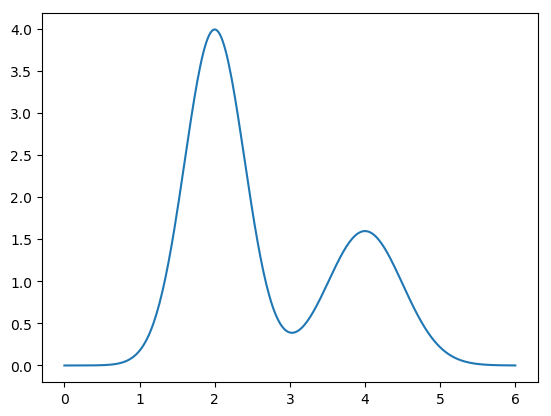

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1a567bdd8>

In [1]:
using PyCall
include("src/gauss_error.jl")
include("src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))

In [2]:
kernel_name = "heaviside"

function kernel(x::Float64, y::Float64)
    return getOpticsKernels(kernel_name)(x, y)
end

kernel (generic function with 1 method)

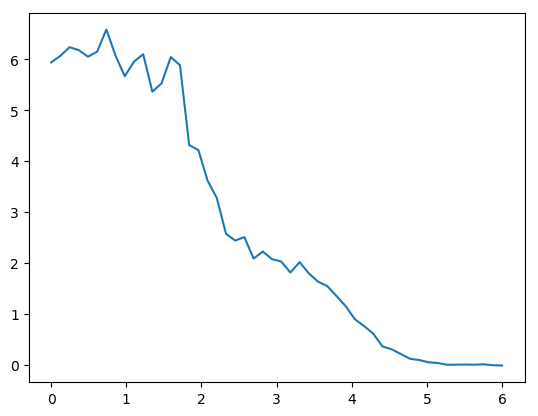

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1a5716128>

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=50))
ftrue = convolution.(y)
sig = 0.05*ftrue + [0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f)

In [22]:
basis = LegendreBasis(a, b, 30)

LegendreBasis(0.0, 6.0, Any[BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[0.0, 1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[0.0, 0.0, 1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[0.0, 0.0, 0.0, 1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[0.0, 0.0, 0.0, 0.0, 1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendr

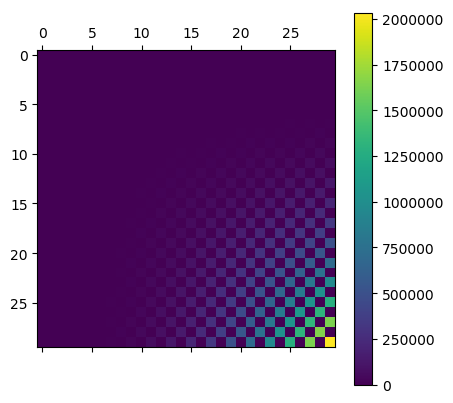

PyObject <matplotlib.colorbar.Colorbar object at 0x1a7c7ab70>

In [23]:
my_omega = omega(basis, 2)
matshow(my_omega[1])
colorbar()

In [24]:
model = GaussErrorUnfolder(basis, omega(basis, 2))

GaussErrorUnfolder(LegendreBasis(0.0, 6.0, Any[BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[0.0, 1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[0.0, 0.0, 1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[0.0, 0.0, 0.0, 1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[0.0, 0.0, 0.0, 0.0, 1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.

In [25]:
phi_reconstruct = solve(model, kernel, f, sig, y)

starting solve
ending solve
starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
Iter     Function value   Gradient norm 
     0    -1.281982e+03     2.129456e+00
     1    -1.285422e+03     3.471696e-02
     2    -1.285422e+03     1.388973e-05
     3    -1.285422e+03     7.431603e-09
ending solve_correct


Dict{String,Array{Float64,N} where N} with 3 entries:
  "alphas" => [0.0799562]
  "coeff"  => [0.979374, -0.234515, -1.72586, 1.25421, -0.502119, -0.449945, 1.…
  "sig"    => [0.00408124 -0.0114839 … -3.25783e-8 4.53014e-8; -0.0114839 0.035…

In [26]:
phivec = PhiVec(phi_reconstruct["coeff"], basis, phi_reconstruct["sig"])

PhiVec([0.979374, -0.234515, -1.72586, 1.25421, -0.502119, -0.449945, 1.18509, 0.156369, -0.997435, -0.0440315  …  0.00262063, -0.00205008, -0.000513819, 0.00117879, 0.000130301, -8.42575e-5, -2.30603e-5, -0.000301166, 7.16365e-7, 0.000135678], LegendreBasis(0.0, 6.0, Any[BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[0.0, 1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[0.0, 0.0, 1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval{Float64},Float64},Float64,Array{Float64,1}}}(0.0, 6.0, Fun(Legendre(),[0.0, 0.0, 0.0, 1.0])), (0.0, 6.0)), BaseFunction(##34#36{Float64,Float64,Fun{Jacobi{ChebyshevInterval

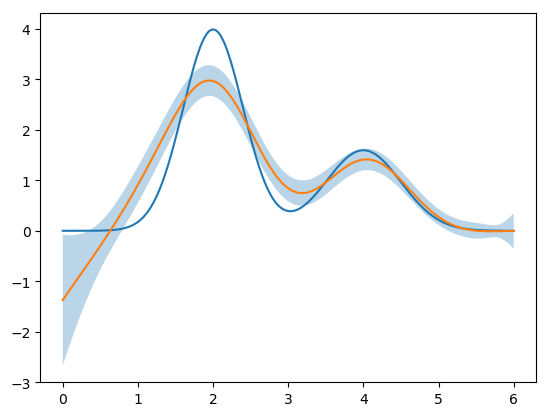

PyObject <matplotlib.collections.PolyCollection object at 0x1a7f12f98>

In [27]:
plot(x, phi.(x))
# title(kernel_name + "kernel")
phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, call(phivec, x))
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)